In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

% matplotlib inline

DATA SET FEATURES EXPLAINED:

PREDICTORS:

RevolvingUtilizationOfUnsecuredLines (utilization) - Total balance on credit cards and personal lines of credit except 
real estate and no installment debt like car loans divided by the sum of credit limits.

NumberOfOpenCreditLinesAndLoans (loans) - Number of Open loans (installment like car loan or mortgage) and Lines of 
credit (e.g. credit cards)

NumberRealEstateLoansOrLines (mortgages) - Number of mortgage and real estate loans including home equity lines 
of credit

NumberOfTime30-59DaysPastDueNotWorse (30_59_days) - Number of times borrower has been 30-59 days past due but no worse 
in the last 2 years

NumberOfTime60-89DaysPastDueNotWorse (60_89_days) - Number of times borrower has been 60-89 days past due but no worse 
in the last 2 years

NumberOfTimes90DaysLate (90_days) - Number of times borrower has been 90 days or more past due

DebtRatio (debt_ratio) - Monthly debt payments, alimony,living costs divided by monthy gross income

MonthlyIncome (income) - Monthly income

age (age) - Age of borrower in years

NumberOfDependents (dependents) - Number of dependents in family excluding themselves (spouse, children etc)


TARGET:

SeriousDlqin2yrs (target) - Person experienced 90 days past due delinquency or worse

HELPERS

In [2]:
##################################################
# DATA CLEANING
##################################################

class DataSetWithoutFalseDebtRatioValues(BaseEstimator, TransformerMixin):
    
    '''
    drop_debt_ratio_if_income_missing (bool): drop debt_ratio value for every row with missing income value  
    '''
    
    def __init__(self):
        return None
        
    def fit(self, train, y = None):
        return self
        
    def transform(self, train, y = None):
        missing_income = train.loc[train['income'].isnull()].index
        train.loc[missing_income, ['debt_ratio']] = np.nan   
        return train
    

def count_missing_values(df):
    missing_values = df.isnull().sum()
    missing_dict = {'n_missing_values' : missing_values,
                    '%_of_total'     : round(100 * missing_values/df.shape[0], 2)}
    return pd.DataFrame(missing_dict)
    

##################################################
# OUTLIER TREATMENT
##################################################
    
class OutlierTreatment(BaseEstimator, TransformerMixin):
    
    def __init__(self, outlier_replacement):
        self.outlier_replacement = outlier_replacement
        
    def fit(self, df, target = None):
        return self
        
    def transform(self, df, target = None):
        for feature in self.outlier_replacement:
            upper_bound = self.outlier_replacement[feature]['upper_bound']
            lower_bound = self.outlier_replacement[feature]['lower_bound']
            lower_replacement = self.outlier_replacement[feature]['lower_replacement']
            upper_replacement = self.outlier_replacement[feature]['upper_replacement']
            special_cases = self.outlier_replacement[feature]['special_cases']

            df.loc[df[df[feature] > upper_bound].index, [feature]] = upper_replacement
            df.loc[df[df[feature] < lower_bound].index, [feature]] = lower_replacement

            if len(special_cases):
                for case in special_cases:
                    df.loc[df[df[feature] == case].index, [feature]] = df[feature].median()
        return df
    
    
def find_outliers(feature):
    '''
    Tukey method: point is an outlier if it is outside the range 
    (1st_quartile - 1.5*IRQ; 3rd_quartile + 1.5*IRQ), where
    IQR = 3rd_quartile - 1st_quartile
    
    return: outliers' indeces
    '''
    
    quartile_1, quartile_3 = np.percentile(feature, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = feature[(feature > upper_bound) | (feature < lower_bound)]
    return outliers.index


def outliers_freq(df, feature):
    outliers = df.loc[find_outliers(df[feature].dropna())]
    return outliers.groupby(feature).count().iloc[:, 0]


def plot_outliers(values, outliers, upper_bound):
    '''
    values (Series): counts of all values within a feature
        values.index - values
        values.values - counts
    outliers (Series): counts of all outliers within a feature
        outliers.index - values
        outliers.values - counts
    upper_bound (int): drop all outliers larger than an upper bound
    '''
    feature = values.index.name
    
    lower_bound = min(outliers.index)

    outliers_to_keep = outliers[outliers.index <= upper_bound]
    outliers_to_drop = outliers[outliers.index >= upper_bound]

    fig, ax = plt.subplots(figsize = (12, 6))

    x_values, y_values = values.index, values.values
    x_outliers_to_keep, y_outliers_to_keep = outliers_to_keep.index, outliers_to_keep.values
    x_outliers_to_drop, y_outliers_to_drop = outliers_to_drop.index, outliers_to_drop.values

    ax.plot(x_values, y_values, color = 'skyblue', label = 'values')
    ax.plot(x_outliers_to_keep, y_outliers_to_keep, color = 'seagreen', label = 'outliers to keep')
    ax.plot(x_outliers_to_drop, y_outliers_to_drop, color = 'orange', label = 'outliers to drop')

    ax.fill_between(x_values, y_values, where = x_values <= lower_bound, color = 'skyblue')
    ax.fill_between(x_outliers_to_keep, y_outliers_to_keep,
                    where = x_outliers_to_keep <= upper_bound, color = 'seagreen')
    ax.fill_between(x_outliers_to_drop, y_outliers_to_drop,
                    where = x_outliers_to_drop >= upper_bound, color = 'orange')

    ax.axvline(x = lower_bound, color = 'seagreen', linestyle = '--')
    ax.axvline(x = upper_bound, color = 'seagreen', linestyle = '--')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlim(0, max(x_values))
    plt.ylim(0, max(y_values))

    max_tick = x_values[-1] + 1
    if max_tick <= 25:
        ticks = np.arange(max_tick)                
        ax.set_xticks(ticks)
    else:
        ticks = np.arange(0, max_tick, 5)
        ax.set_xticks(ticks)

    plt.xlabel(feature, fontsize = 12)
    plt.ylabel('count', fontsize = 12)

    plt.legend(fontsize = 12, frameon = False)
    plt.title('Distribution of {}'.format(feature).title(), fontsize = 14);
    
def plot_boxplot(train, feature):

    fig, ax = plt.subplots(figsize = (12, 4))
    ax.boxplot(train[feature].values, vert = False)

    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    max_tick = train[feature].max()
    ticks = np.arange(0, max_tick, 5)                
    ax.set_xticks(ticks)

    plt.title('{} outliers'.format(feature).title());    
    
def plot_tables(tables):
    
    number_of_tables = len(tables)
    fig, axes = plt.subplots(1, number_of_tables, figsize = (8,4))

    for ax in axes:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    for i, table in enumerate(tables):
        axes[i].table(cellText = table.values, colLabels = table.columns, loc='left');
        
def feature_vs_outliers_stats(feature):
    df = pd.DataFrame(train[feature].describe())
    outliers = train.loc[find_outliers(train[feature].dropna()), :][feature].describe()
    outliers_df = pd.DataFrame(outliers)
    return df.join(outliers_df, rsuffix = '_outlier')


##################################################
# FEATURE ENGINEERING
##################################################

class NewFeature(BaseEstimator, TransformerMixin):
    
    def __init__(self, pca, features):
        self.pca = pca
        self.features = features
        
    def fit(self, train, y = None):
        return self
        
    def transform(self, train, y = None):
        train['n_days'] = self.pca.transform(train.loc[:, self.features])
        train = train.drop(self.features, axis = 1)
        return train

Training pipeline:
    1. remove debt_ratio values for records with missing income values
    2. treat outliers individually and design outlier treatment pipeline
        - use outlier treatment pipeline for testing set
    3. fit regressors and predict missing values
    4. put predicted missing values in training set
        - use these regressors later to process missing values in testing set
    5. design features, try dimensionality reduction
    6. remove noise, do pca with n-1 components
    7. scaling the data, try standartisation
    7. fit models and compare performance
    8. select top 3 and fine tune them
    9. use ensemble method to improve prediction

DATA PREPROCESSING

In [3]:
# import data
data = pd.read_csv('train.csv', index_col = 0)

# rename columns to improve readability
new_columns = ['target', 'utilization', 'age', '30_59_days', 'debt_ratio', 'income',
               'loans', '90_days', 'mortgages', '60_89_days', 'dependents']
data.columns = new_columns

In [4]:
# split dataset
target = data['target']
features = data.drop('target', axis = 1)

In [5]:
procent_of_positives = round(100 * target.sum()/target.shape[0], 2)
print ('% of positives in target: {}%'.format(procent_of_positives))

% of positives in target: 6.68%


In [6]:
# use stratify to make sure both training and testing sets are imbalanced the same way
train, test, target_train, target_test = train_test_split(features, target, stratify = target, 
                                                          test_size = 0.25, random_state = 42)
print ('% of positives in train target: {}%'.format(round(100 * target_train.sum()/target_train.shape[0], 2)))
print ('% of positives in test target: {}%'.format(round(100 * target_test.sum()/target_test.shape[0], 2)))

% of positives in train target: 6.68%
% of positives in test target: 6.68%


In [7]:
count_missing_values(train)

,%_of_total,n_missing_values
utilization,0.00,0
age,0.00,0
30_59_days,0.00,0
debt_ratio,0.00,0
income,19.72,22187
loans,0.00,0
90_days,0.00,0
mortgages,0.00,0
60_89_days,0.00,0
dependents,2.62,2945


Almost 20% of data points miss income values. It is given that debt_ratio variable is calculated as debt/income. Let's check if debt_ratio feature tend to have outliers due to missing income values. If that is the case, than persons with extreme values of debt_ratio values do not necessarily overspend as data suggests.

In [8]:
missing_income = train.loc[train['income'].isnull()].index
outliers_debt_ratio = find_outliers(train['debt_ratio'])

# number of records for which both missing income and outliers for debt_ratio present 
records = list(set(missing_income).intersection(outliers_debt_ratio))
both = len(records)
# % of such records from total number of outliers
proc = both / len(outliers_debt_ratio)
print ('{}%'.format(100*round(proc, 3)))

89.1%


Thus 89% of all records having outliers in debt_ratio also have income values missing. As debt ratio is calculated as debt/income it is worth to suggest that corresponding debt_ratio values are not calculated correctly. So, it makes sense to remove the corresponding values of debt_ratio variable and predict them together with missing values of income variable.

In [9]:
pipeline = Pipeline([
    ('no_false_debt_ratio', DataSetWithoutFalseDebtRatioValues())
]);
train = pipeline.fit_transform(train.copy())
count_missing_values(train)

,%_of_total,n_missing_values
utilization,0.00,0
age,0.00,0
30_59_days,0.00,0
debt_ratio,19.72,22187
income,19.72,22187
loans,0.00,0
90_days,0.00,0
mortgages,0.00,0
60_89_days,0.00,0
dependents,2.62,2945


OUTLIERS

High ratio of number of positives having at least one outlier in any feature to total number of positives suggests that reasonable extremes should be kept in explanatory dataset. Let's find this ratio. 

In [10]:
indeces_positives = target_train[target_train == 1].index
indeces_negatives = target_train[target_train == 0].index

indeces_all_outliers = []
for feature in train:
    indeces_all_outliers.append(find_outliers(train[feature].dropna()))
indeces_all_outliers = [outlier for feature_outliers in indeces_all_outliers for outlier in feature_outliers]

positives_having_outlier = list(set(indeces_positives).intersection(indeces_all_outliers))
negatives_having_outlier = list(set(indeces_negatives).intersection(indeces_all_outliers))

pos_ratio = round(100 * len(positives_having_outlier) / len(indeces_positives), 2)
print ('{}% of positives have an outlier in at least one feature'.format(pos_ratio))
neg_ratio = round(100 * len(negatives_having_outlier) / len(indeces_negatives), 2)
print ('{}% of negatives have an outlier in at least one feature'.format(neg_ratio))

75.44% of positives have an outlier in at least one feature
31.4% of negatives have an outlier in at least one feature


In [11]:
ratios = {
    'outliers_class_0_ratios' : [round(neg_ratio, 0), round(100 - neg_ratio, 0)],
    'outliers_class_1_ratios' : [round(pos_ratio, 0), round(100 - pos_ratio, 0)]}
outliers_labels = ['at least one feature is an outlier', 'no outliers accross features']

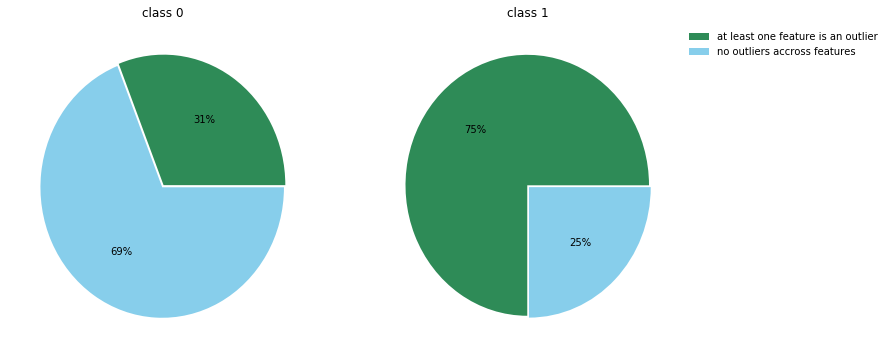

In [12]:
fig, axes = plt.subplots(1,2, figsize = (12, 6))
for i, values in enumerate(ratios.values()):
    axes[i].pie(values, autopct = '%.0f%%', colors = ['seagreen', 'skyblue'], explode = [0.01, 0.01])
    axes[i].set_title('class {}'.format(i));
plt.legend(outliers_labels, loc = 2, bbox_to_anchor=(1, 1), frameon = False);

So, given an imbalanced target with less than 7% of positives and about 75% of them having an outlier in at least one feature, it seems plausible to keep reasonable outlires where possible. If an outlier is replaced with feature's median then the corresponding record would tend to be similar to a negative class, but the data suggest the opposite. Hence, whenever an outlier is met it gets replaced with the smallest outlier of the corresponding feature. This approach preserves the information that value is extreme, but removes large extremes that skew feature's distribution. For some features, the threshold for outlier selection will be moved towards more extreme values as it is justified by domain knowledge. Let's look at each feature individually and design the custom outlier treatment procedure.

DEPENDENTS

In [13]:
feature = 'dependents'

# values
dependents = train.groupby(feature).count().iloc[:, 0]
dependents_df = pd.DataFrame(dependents)
dependents_df.reset_index(inplace = True)
dependents_df.columns = [feature, 'count']
dependents_df[feature] = dependents_df[feature].apply(lambda x: int(x))

# outliers
dependents_outliers = outliers_freq(train, feature)
dependents_outliers_df = pd.DataFrame(dependents_outliers)
dependents_outliers_df.reset_index(inplace = True)
dependents_outliers_df.columns = ['outliers', 'count']
dependents_outliers_df['outliers'] = dependents_outliers_df['outliers'].apply(lambda x: int(x))

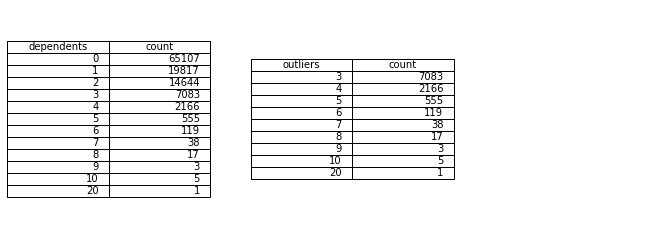

In [14]:
plot_tables([dependents_df, dependents_outliers_df])

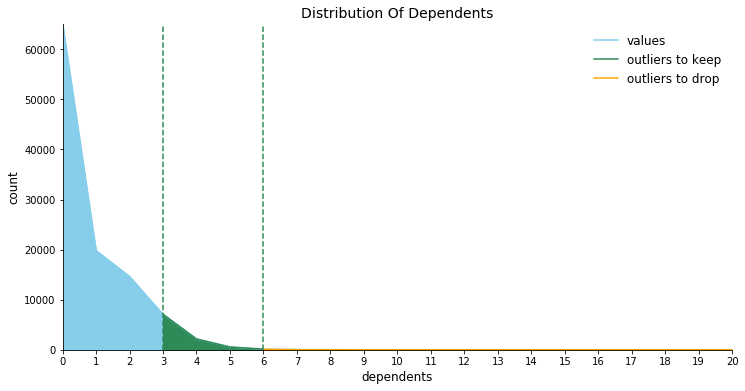

In [15]:
plot_outliers(dependents, dependents_outliers, upper_bound = 6)

Significant number of borrowers have more than 2 dependents and very few more than 6. The outliers treatment rule for dependents - all values larger than 6 should be replaced with 6s.

AGE

In [16]:
feature = 'age'

# values
age = train.groupby(feature).count().iloc[:, 0]
age_df = pd.DataFrame(age)
age_df.reset_index(inplace = True)
age_df.columns = [feature, 'count']

# left_tale
age_left_tail_df = age_df.iloc[:10]

# right_tale
age_right_tail_df = age_df.iloc[-10:]

# outliers
age_outliers = outliers_freq(train, feature)
age_outliers_df = pd.DataFrame(age_outliers)
age_outliers_df.reset_index(inplace = True)
age_outliers_df.columns = ['outliers', 'count']

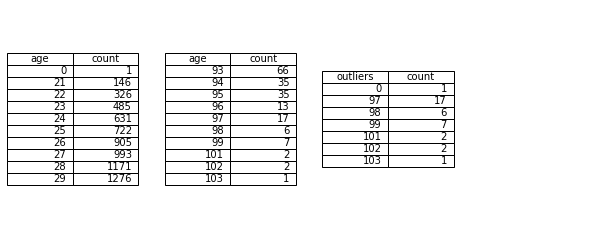

In [17]:
plot_tables([age_left_tail_df, age_right_tail_df, age_outliers_df])

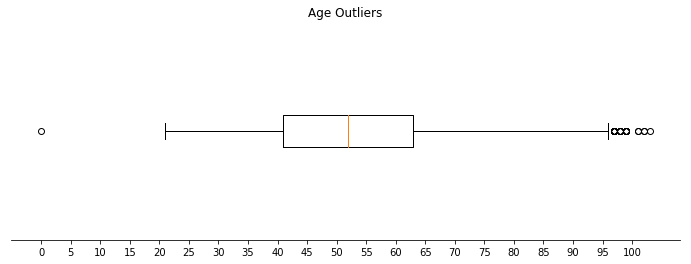

In [18]:
plot_boxplot(train, 'age')

Age = 0 is obviously a bogus value, let's replace it with feature's median.

In [19]:
train.loc[train.loc[train[feature] == 0].index, [feature]] = train[feature].median()

The outlier treatment rule for age - custom: there are no borrowers older than 21 years. This might be a legal requirement for the lender. So, all values smaller 21 are treated as incorrect and replaced with age's median. As to outliers, they all replaced with 97 as it is the smallest outlier.

LOANS

In [20]:
feature = 'loans'

# values
loans = train.groupby(feature).count().iloc[:, 0]
loans_df = pd.DataFrame(loans)
loans_df.reset_index(inplace = True)
loans_df.columns = [feature, 'count']

# outliers
loans_outliers = outliers_freq(train, feature)
loans_outliers_df = pd.DataFrame(loans_outliers)
loans_outliers_df.reset_index(inplace = True)
loans_outliers_df.columns = ['outliers', 'count']

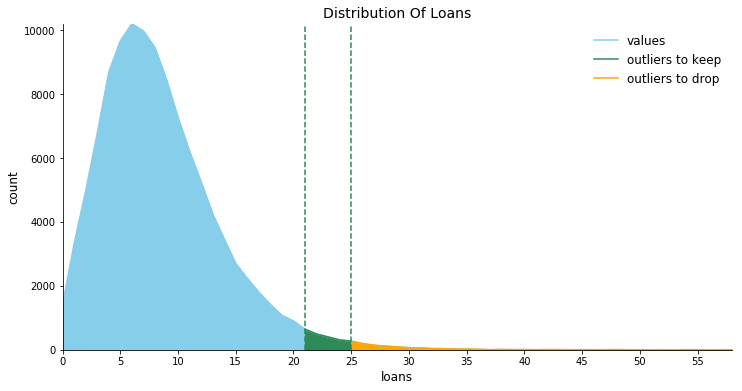

In [21]:
plot_outliers(loans, loans_outliers, upper_bound = 25)

Still for significant number of borrowers the value of loans feature is between 21 and 25. The outliers treatment rule for loans - all values larger than 25 should be replaced with 25.

MORTGAGES

In [22]:
feature = 'mortgages'

# values
mortgages = train.groupby(feature).count().iloc[:, 0]
mortgages_df = pd.DataFrame(mortgages)
mortgages_df.reset_index(inplace = True)
mortgages_df.columns = [feature, 'count']

# outliers
mortgages_outliers = outliers_freq(train, feature)
mortgages_outliers_df = pd.DataFrame(mortgages_outliers)
mortgages_outliers_df.reset_index(inplace = True)
mortgages_outliers_df.columns = ['outliers', 'count']

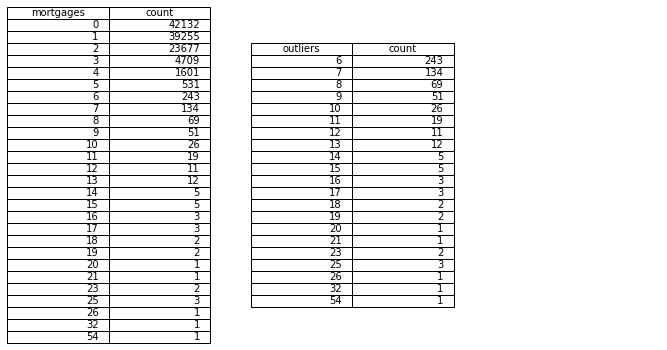

In [23]:
plot_tables([mortgages_df, mortgages_outliers_df])

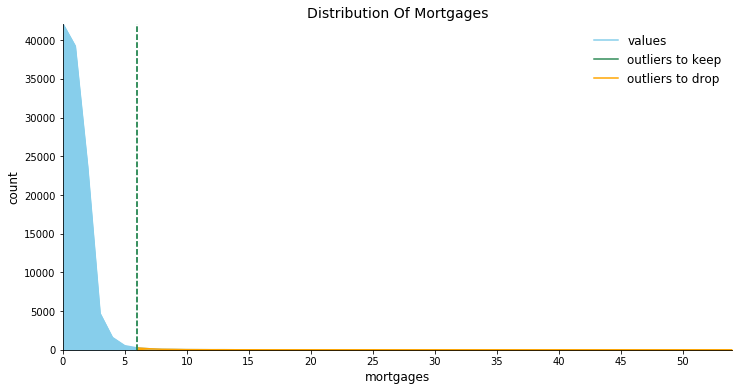

In [24]:
plot_outliers(mortgages, mortgages_outliers, upper_bound = 6)

The outliers treatment rule for mortgages - all outliers should be replaced with the smallest outlier = 6.

30_59_DAYS

In [25]:
feature = '30_59_days'

# values
days_30_59 = train.groupby(feature).count().iloc[:, 0]
days_30_59_df = pd.DataFrame(days_30_59)
days_30_59_df.reset_index(inplace = True)
days_30_59_df.columns = [feature, 'count']

# outliers
days_30_59_outliers = outliers_freq(train, feature)
days_30_59_outliers_df = pd.DataFrame(days_30_59_outliers)
days_30_59_outliers_df.reset_index(inplace = True)
days_30_59_outliers_df.columns = ['outliers', 'count']

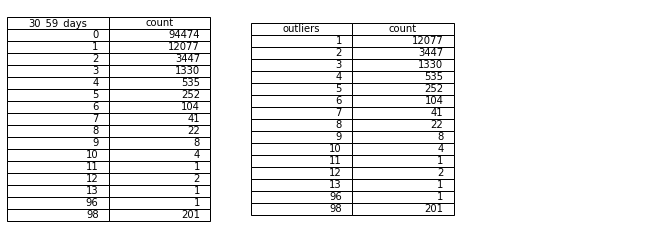

In [26]:
plot_tables([days_30_59_df, days_30_59_outliers_df])

All three features, representing the number of times borrower has been X days or more past due, contains values 96 and 98. These values are much larger their closest neighbours. It looks like these values are not correct, may appear in the dataset by some collection mistake. Hence, 96 and 98 are special cases and should be replaced with feature's median.

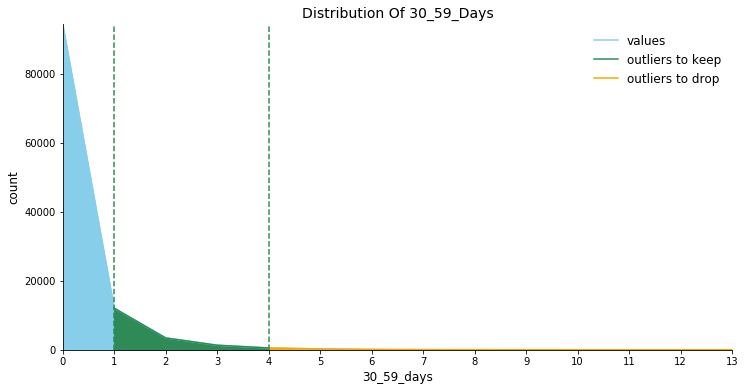

In [27]:
plot_outliers(days_30_59[:-2], days_30_59_outliers[:-2], upper_bound = 4)

The outlier treatment rule for 30_59_days feature - treat values 96 and 98 as missing values and replace them with median. All values larger than 4 should be replaced with 4s.

60_89_DAYS

In [28]:
feature = '60_89_days'

# values
days_60_89 = train.groupby(feature).count().iloc[:, 0]
days_60_89_df = pd.DataFrame(days_60_89)
days_60_89_df.reset_index(inplace = True)
days_60_89_df.columns = [feature, 'count']

# outliers
days_60_89_outliers = outliers_freq(train, feature)
days_60_89_outliers_df = pd.DataFrame(days_60_89_outliers)
days_60_89_outliers_df.reset_index(inplace = True)
days_60_89_outliers_df.columns = ['outliers', 'count']

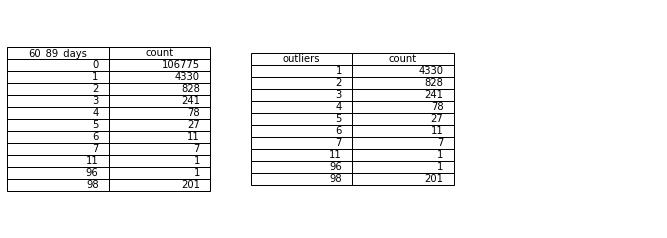

In [29]:
plot_tables([days_60_89_df, days_60_89_outliers_df])

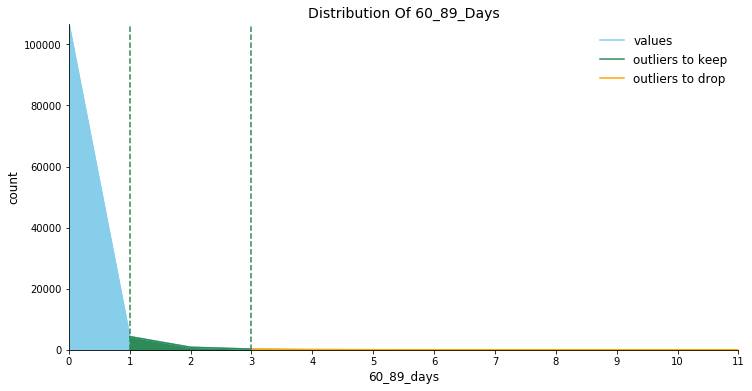

In [30]:
plot_outliers(days_60_89[:-2], days_60_89_outliers[:-2], upper_bound = 3)

The outlier treatment rule for 60_89_days feature - treat values 96 and 98 as missing values and replace them with median. All values larger than 3 should be replaced with 3s.

90_DAYS

In [31]:
feature = '90_days'

# values
days_90 = train.groupby(feature).count().iloc[:, 0]
days_90_df = pd.DataFrame(days_90)
days_90_df.reset_index(inplace = True)
days_90_df.columns = [feature, 'count']

# outliers
days_90_outliers = outliers_freq(train, feature)
days_90_outliers_df = pd.DataFrame(days_90_outliers)
days_90_outliers_df.reset_index(inplace = True)
days_90_outliers_df.columns = ['outliers', 'count']

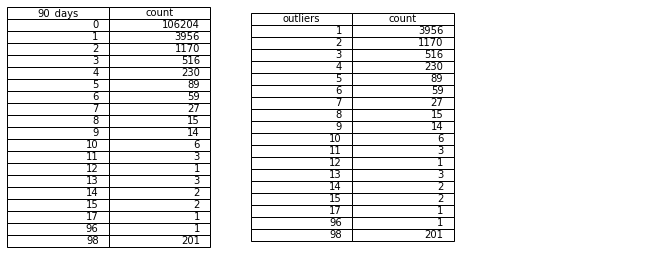

In [32]:
plot_tables([days_90_df, days_90_outliers_df])

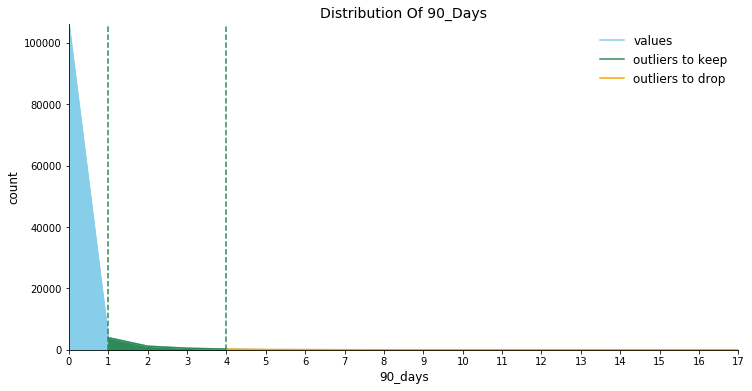

In [33]:
plot_outliers(days_90[:-2], days_90_outliers[:-2], upper_bound = 4)

The outlier treatment rule for 90_days feature - treat values 96 and 98 as missing values and replace them with median. All values larger than 4 should be replaced with 4s.

UTILIZATION

In [34]:
feature_vs_outliers_stats('utilization')

,utilization,utilization_outlier
count,112500.000000,591.000000
mean,6.264202,1132.502363
std,259.629816,3402.314257
min,0.000000,1.352159
25%,0.029678,1.534899
50%,0.153517,1.947631
75%,0.558305,648.000000
max,50708.000000,50708.000000


The outlier treatment rule for utilization feature - as utilization is the otal balance on credit cards and personal lines of credit divided by the sum of credit limits, then a value greater than 1 suggests that total balance across all credit lines exceeds the total credit limit. Is it possible? Let's make an assumption that credit providers do not allow to exceed the credit limit. Hence, all values greater than 1 identify the person as an active borrower. Although, the smallest outlier is 1.35, all values greater than 1 should be replaced with 1.

INCOME

In [35]:
feature_vs_outliers_stats('income')

,income,income_outlier
count,9.031300e+04,3.688000e+03
mean,6.661173e+03,2.793353e+04
std,1.486999e+04,6.849820e+04
min,0.000000e+00,1.550900e+04
25%,3.400000e+03,1.700000e+04
50%,5.400000e+03,1.933300e+04
75%,8.242000e+03,2.500000e+04
max,3.008750e+06,3.008750e+06


The outlier treatment rule for income feature - the smallest income outlier is 15,509, hence all values larger than that should be replaced with it. 

DEBT_RATIO

In [36]:
feature_vs_outliers_stats('debt_ratio')

,debt_ratio,debt_ratio_outlier
count,90313.000000,5528.000000
mean,25.699128,415.175273
std,374.460828,1459.321253
min,0.000000,0.990563
25%,0.143817,1.196572
50%,0.296426,1.693895
75%,0.482507,41.000000
max,60212.000000,60212.000000


The outlier treatment rule for debt_ratio feature - the smallest income outlier is 0.99, hence all values larger than that should be replaced with it. 

OUTLIERS TREATMENT

Now, let's summarize all outliers' thresholds into a dictonary. For those features with no lower bound, the check for negative values is added instead.

In [37]:
outlier_replacement = {
    'dependents': {
        'upper_bound' : 6,
        'upper_replacement' : 6,        
        'lower_bound' : 0,
        'lower_replacement' : train['dependents'].median(),
        'special_cases' : []
    }
    ,'age': {
        'upper_bound' : 97,
        'upper_replacement' : 97,        
        'lower_bound' : 21,
        'lower_replacement' : train['age'].median(),
        'special_cases' : []
    }
    ,'loans': {
        'upper_bound' : 25,
        'upper_replacement' : 25,
        'lower_bound' : 0,
        'lower_replacement' : train['loans'].median(),
        'special_cases' : []
    }
    ,'mortgages': {
        'upper_bound' : 6,
        'upper_replacement' : 6,
        'lower_bound' : 0,
        'lower_replacement' : train['mortgages'].median(),
        'special_cases' : []
    }
    ,'30_59_days': {
        'upper_bound' : 4,
        'upper_replacement' : 4,
        'lower_bound' : 0,
        'lower_replacement' : train['30_59_days'].mode(),
        'special_cases' : [96, 98]
    }
    ,'60_89_days': {
        'upper_bound' : 3,
        'upper_replacement' : 3,
        'lower_bound' : 0,
        'lower_replacement' : train['60_89_days'].mode(),
        'special_cases' : [96, 98]
    }
    ,'90_days': {
        'upper_bound' : 4,
        'upper_replacement' : 4,
        'lower_bound' : 0,
        'lower_replacement' : train['90_days'].mode(),
        'special_cases' : [96, 98]
    }
    ,'utilization': {
        'upper_bound' : 1,
        'upper_replacement' : 1,
        'lower_bound' : 0,
        'lower_replacement' : train['utilization'].median(),
        'special_cases' : []
    }
    ,'income': {
        'upper_bound' : 15509,
        'upper_replacement' : 15509,
        'lower_bound' : 0,
        'lower_replacement' : train['income'].median(),
        'special_cases' : []
    }
    ,'debt_ratio': {
        'upper_bound' : 0.99,
        'upper_replacement' : 0.99,
        'lower_bound' : 0,
        'lower_replacement' : train['debt_ratio'].median(),
        'special_cases' : []
    }
}

In [38]:
pipeline = Pipeline([
    ('outlier', OutlierTreatment(outlier_replacement))
]);
train = pipeline.fit_transform(train.copy())

CORRELATION PATTERNS

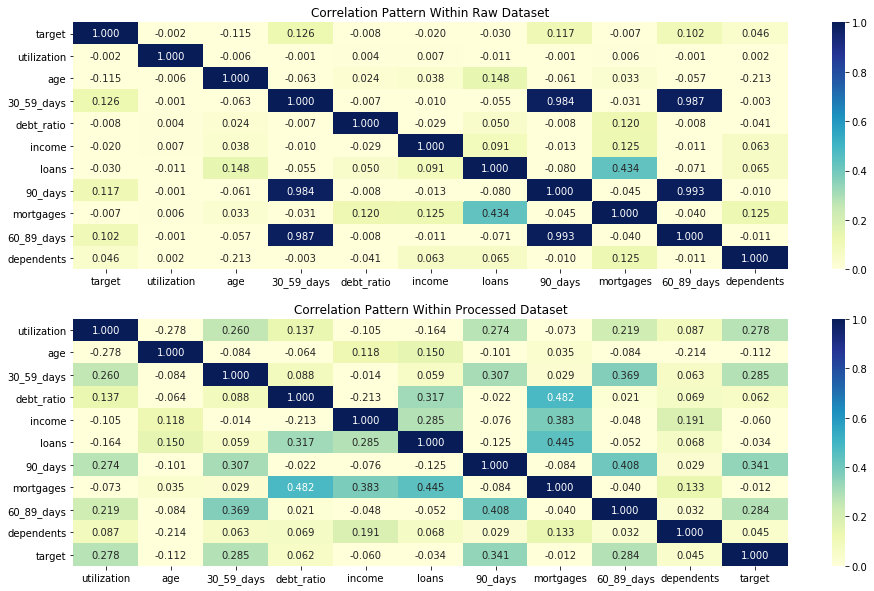

In [39]:
# visualise correlation between features
fig, axes = plt.subplots(2,1, figsize = (16,10))
sb.heatmap(data.corr(), vmin = 0, vmax = 1, annot = True, fmt = '.3f', cbar = True, cmap = 'YlGnBu', ax = axes[0])
sb.heatmap(pd.concat([train, target_train], axis = 1).corr(), vmin = 0, vmax = 1, 
           annot = True, fmt = '.3f', cbar = True, cmap = 'YlGnBu', ax = axes[1])
axes[0].set_title('Correlation Pattern Within Raw Dataset');
axes[1].set_title('Correlation Pattern Within Processed Dataset');